# CNN on CIFAR10 with Adam

In [1]:
!pip install wandb==0.9.7
!wandb login

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
wandb: You can find your API key in your browser here: https://app.wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 8fce5ee4a321acdc93b1ab718535a737dc60ad84
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
Successfully logged in to Weights & Biases!


## Import libraries

In [2]:
import torch
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
from tqdm.auto import tqdm
import time
import matplotlib.pyplot as plt
from PIL import Image

import wandb

device = torch.device("mps" if getattr(torch,'has_mps',False) else "cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

BATCH_SIZE = 256

cuda:0


## Load dataset

In [3]:
def load_data():
    img_shape = (32, 32)
    transform_train = transforms.Compose([
        transforms.Resize(img_shape, Image.BILINEAR),
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        # transforms.Normalize((0.5,), (0.5,))
    ])
    transform_test = transforms.Compose([
        transforms.Resize(img_shape, Image.BILINEAR),
        transforms.ToTensor(),
        # transforms.Normalize((0.5,), (0.5,))
    ])
    train_data = datasets.CIFAR10(root = 'data', train = True, download = True, transform = transform_train)
    test_data = datasets.CIFAR10(root = 'data', train = False, download = True, transform = transform_test)
    print('Number of training data:', len(train_data))
    print('Number of testing data:', len(test_data))

    train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

    return train_data, test_data, train_loader, test_loader
  
train_data, test_data, train_loader, test_loader = load_data()

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/transforms.py:329: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


Files already downloaded and verified
Files already downloaded and verified
Number of training data: 50000
Number of testing data: 10000


## Build model

In [4]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(3, 32, 5, 1, 2, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),                      
            nn.MaxPool2d(2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(32, 64, 5, 1, 2, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        self.out = nn.Linear(4096, 100, bias=False)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output

In [5]:
def train(model, train_loader, optimizer, loss_func, epochs=30):
    accuracy_lst_train = []
    loss_lst_train = []
    accuracy_lst_val = []
    loss_lst_val = []
    for epoch in tqdm(range(epochs), desc=f"Training progress", colour="#00ff00"):
        model.train()
        total_loss = 0
        correct = 0
        num_labels = 0
        counter = 0
        for batch_idx, (X, y) in enumerate(tqdm(train_loader, leave=False, desc=f"Epoch {epoch + 1}/{epochs}", colour="#005500")):
            X = X.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            output = model(X)
            loss = loss_func(output, y)
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
            predicted = torch.max(output.data, 1)[1]
            correct += (predicted == y).sum()
            num_labels += len(y)
            counter += 1
        accuracy_lst_train.append((correct/num_labels).cpu().item())
        loss_lst_train.append(total_loss/counter)

        # Validation
        model.eval()
        total_loss_val = 0
        correct_val = 0
        num_labels_val = 0
        counter_val = 0
        model.eval()
        for batch_idx, (X, y) in enumerate(test_loader):
            X = X.to(device)
            y = y.to(device)

            output = model(X)

            loss = loss_func(output, y)
            total_loss_val += loss.item()

            predicted = torch.max(output,1)[1]
            correct_val += (predicted == y).sum()
            num_labels_val += len(y)
            counter_val += 1
        loss_lst_val.append(total_loss_val/counter_val)
        accuracy_lst_val.append((correct_val/num_labels_val).cpu().item())

        # Log
        wandb.log({'Training Accuracy': accuracy_lst_train[-1], 'Training Loss': loss_lst_train[-1], 'Testing Accuracy': accuracy_lst_val[-1], 'Testing Loss': loss_lst_val[-1]})

        print('Epoch %d, Training Loss %4f, Training Accuracy %4f, Testing Loss %4f, Testing Accuracy %4f'
            % (epoch+1, total_loss/counter, correct/num_labels, total_loss_val/counter_val, correct_val/num_labels_val))
    return accuracy_lst_train, loss_lst_train, accuracy_lst_val, loss_lst_val

## Train with different optimizers

In [6]:
lr = 0.001

model = CNN().to(device)
print(model)

loss_func = nn.CrossEntropyLoss()

CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=4096, out_features=100, bias=False)
)


In [7]:
num_epoch = 100

In [8]:
lr = 0.001
# Adam


optimizer = torch.optim.Adam(model.parameters(), lr = lr, weight_decay=5e-4)
Adam_run = wandb.init(project="CSI 5340 Project", entity="csi5340", name='Adam')
wandb.watch(model, log="all", log_freq=10)

accuracy_lst_train, loss_lst_train, accuracy_lst_val, loss_lst_val = train(model, train_loader, optimizer, loss_func, num_epoch)

#Adam_run.finish()

wandb: Wandb version 0.13.6 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Training progress:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100:   0%|          | 0/196 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1113: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Epoch 1, Training Loss 1.559640, Training Accuracy 0.438580, Testing Loss 1.400254, Testing Accuracy 0.513200


Epoch 2/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 2, Training Loss 1.227144, Training Accuracy 0.563920, Testing Loss 1.049694, Testing Accuracy 0.625300


Epoch 3/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 3, Training Loss 1.112936, Training Accuracy 0.607620, Testing Loss 1.419554, Testing Accuracy 0.531700


Epoch 4/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 4, Training Loss 1.054996, Training Accuracy 0.631780, Testing Loss 1.207345, Testing Accuracy 0.588500


Epoch 5/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 5, Training Loss 1.006635, Training Accuracy 0.648180, Testing Loss 1.020165, Testing Accuracy 0.646700


Epoch 6/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 6, Training Loss 0.959848, Training Accuracy 0.665520, Testing Loss 1.199950, Testing Accuracy 0.589800


Epoch 7/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 7, Training Loss 0.926538, Training Accuracy 0.676500, Testing Loss 0.919080, Testing Accuracy 0.691100


Epoch 8/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 8, Training Loss 0.905705, Training Accuracy 0.686760, Testing Loss 0.882376, Testing Accuracy 0.699600


Epoch 9/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 9, Training Loss 0.877787, Training Accuracy 0.696520, Testing Loss 0.889463, Testing Accuracy 0.691400


Epoch 10/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 10, Training Loss 0.865162, Training Accuracy 0.698100, Testing Loss 1.130064, Testing Accuracy 0.617500


Epoch 11/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 11, Training Loss 0.845478, Training Accuracy 0.709380, Testing Loss 0.923137, Testing Accuracy 0.685800


Epoch 12/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 12, Training Loss 0.833281, Training Accuracy 0.709660, Testing Loss 0.817331, Testing Accuracy 0.715700


Epoch 13/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 13, Training Loss 0.813412, Training Accuracy 0.717820, Testing Loss 0.845135, Testing Accuracy 0.708600


Epoch 14/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 14, Training Loss 0.807742, Training Accuracy 0.720800, Testing Loss 0.895891, Testing Accuracy 0.694900


Epoch 15/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 15, Training Loss 0.788548, Training Accuracy 0.726840, Testing Loss 1.220885, Testing Accuracy 0.646500


Epoch 16/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 16, Training Loss 0.790515, Training Accuracy 0.727100, Testing Loss 0.882600, Testing Accuracy 0.705900


Epoch 17/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 17, Training Loss 0.775157, Training Accuracy 0.731880, Testing Loss 0.967553, Testing Accuracy 0.684800


Epoch 18/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 18, Training Loss 0.761477, Training Accuracy 0.737000, Testing Loss 0.841900, Testing Accuracy 0.705100


Epoch 19/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 19, Training Loss 0.767283, Training Accuracy 0.734540, Testing Loss 0.956758, Testing Accuracy 0.680900


Epoch 20/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 20, Training Loss 0.749826, Training Accuracy 0.740320, Testing Loss 0.781643, Testing Accuracy 0.737700


Epoch 21/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 21, Training Loss 0.734335, Training Accuracy 0.746080, Testing Loss 1.148696, Testing Accuracy 0.638800


Epoch 22/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 22, Training Loss 0.724915, Training Accuracy 0.750000, Testing Loss 0.784548, Testing Accuracy 0.730100


Epoch 23/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 23, Training Loss 0.723769, Training Accuracy 0.751260, Testing Loss 0.994797, Testing Accuracy 0.678600


Epoch 24/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 24, Training Loss 0.716086, Training Accuracy 0.753560, Testing Loss 0.743650, Testing Accuracy 0.746900


Epoch 25/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 25, Training Loss 0.709376, Training Accuracy 0.756120, Testing Loss 0.867674, Testing Accuracy 0.710200


Epoch 26/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 26, Training Loss 0.701783, Training Accuracy 0.757960, Testing Loss 0.850871, Testing Accuracy 0.717200


Epoch 27/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 27, Training Loss 0.702989, Training Accuracy 0.758460, Testing Loss 0.740043, Testing Accuracy 0.745900


Epoch 28/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 28, Training Loss 0.689419, Training Accuracy 0.764620, Testing Loss 0.804651, Testing Accuracy 0.734600


Epoch 29/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 29, Training Loss 0.692475, Training Accuracy 0.759660, Testing Loss 0.835703, Testing Accuracy 0.734500


Epoch 30/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 30, Training Loss 0.682630, Training Accuracy 0.765680, Testing Loss 0.800703, Testing Accuracy 0.731300


Epoch 31/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 31, Training Loss 0.680141, Training Accuracy 0.766020, Testing Loss 0.743874, Testing Accuracy 0.747700


Epoch 32/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 32, Training Loss 0.675084, Training Accuracy 0.765480, Testing Loss 0.975996, Testing Accuracy 0.701500


Epoch 33/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 33, Training Loss 0.671193, Training Accuracy 0.768200, Testing Loss 0.873596, Testing Accuracy 0.709400


Epoch 34/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 34, Training Loss 0.667499, Training Accuracy 0.769900, Testing Loss 0.701759, Testing Accuracy 0.760000


Epoch 35/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 35, Training Loss 0.661678, Training Accuracy 0.773300, Testing Loss 1.046550, Testing Accuracy 0.656700


Epoch 36/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 36, Training Loss 0.656951, Training Accuracy 0.774580, Testing Loss 0.927524, Testing Accuracy 0.698700


Epoch 37/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 37, Training Loss 0.658361, Training Accuracy 0.772980, Testing Loss 0.832247, Testing Accuracy 0.710800


Epoch 38/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 38, Training Loss 0.646534, Training Accuracy 0.776240, Testing Loss 0.687000, Testing Accuracy 0.760300


Epoch 39/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 39, Training Loss 0.652469, Training Accuracy 0.774680, Testing Loss 1.043592, Testing Accuracy 0.662400


Epoch 40/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 40, Training Loss 0.641038, Training Accuracy 0.780460, Testing Loss 0.831092, Testing Accuracy 0.719100


Epoch 41/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 41, Training Loss 0.644595, Training Accuracy 0.779200, Testing Loss 0.873013, Testing Accuracy 0.717300


Epoch 42/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 42, Training Loss 0.635554, Training Accuracy 0.781100, Testing Loss 0.737948, Testing Accuracy 0.747900


Epoch 43/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 43, Training Loss 0.633609, Training Accuracy 0.782580, Testing Loss 0.740640, Testing Accuracy 0.748400


Epoch 44/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 44, Training Loss 0.637578, Training Accuracy 0.780960, Testing Loss 1.337189, Testing Accuracy 0.595000


Epoch 45/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 45, Training Loss 0.636631, Training Accuracy 0.779760, Testing Loss 0.831745, Testing Accuracy 0.717300


Epoch 46/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 46, Training Loss 0.626922, Training Accuracy 0.784380, Testing Loss 0.737930, Testing Accuracy 0.758700


Epoch 47/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 47, Training Loss 0.621426, Training Accuracy 0.786500, Testing Loss 0.669857, Testing Accuracy 0.770900


Epoch 48/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 48, Training Loss 0.619705, Training Accuracy 0.787300, Testing Loss 0.763058, Testing Accuracy 0.748300


Epoch 49/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 49, Training Loss 0.620999, Training Accuracy 0.787480, Testing Loss 0.719370, Testing Accuracy 0.766200


Epoch 50/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 50, Training Loss 0.624504, Training Accuracy 0.783520, Testing Loss 0.811186, Testing Accuracy 0.737300


Epoch 51/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 51, Training Loss 0.613112, Training Accuracy 0.790720, Testing Loss 0.678934, Testing Accuracy 0.772400


Epoch 52/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 52, Training Loss 0.618727, Training Accuracy 0.789140, Testing Loss 1.005689, Testing Accuracy 0.683900


Epoch 53/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 53, Training Loss 0.609712, Training Accuracy 0.791760, Testing Loss 0.913390, Testing Accuracy 0.711000


Epoch 54/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 54, Training Loss 0.607603, Training Accuracy 0.790940, Testing Loss 0.703029, Testing Accuracy 0.767100


Epoch 55/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 55, Training Loss 0.601572, Training Accuracy 0.792380, Testing Loss 0.891298, Testing Accuracy 0.709800


Epoch 56/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 56, Training Loss 0.600819, Training Accuracy 0.794760, Testing Loss 0.699623, Testing Accuracy 0.767200


Epoch 57/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 57, Training Loss 0.599688, Training Accuracy 0.793880, Testing Loss 0.825595, Testing Accuracy 0.720300


Epoch 58/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 58, Training Loss 0.605497, Training Accuracy 0.792400, Testing Loss 0.905963, Testing Accuracy 0.704100


Epoch 59/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 59, Training Loss 0.594210, Training Accuracy 0.794940, Testing Loss 1.025227, Testing Accuracy 0.699000


Epoch 60/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 60, Training Loss 0.603515, Training Accuracy 0.792580, Testing Loss 0.776560, Testing Accuracy 0.737800


Epoch 61/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 61, Training Loss 0.595516, Training Accuracy 0.796660, Testing Loss 0.741437, Testing Accuracy 0.753200


Epoch 62/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 62, Training Loss 0.590144, Training Accuracy 0.797080, Testing Loss 0.717367, Testing Accuracy 0.760700


Epoch 63/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 63, Training Loss 0.584373, Training Accuracy 0.799380, Testing Loss 0.702115, Testing Accuracy 0.766700


Epoch 64/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 64, Training Loss 0.585444, Training Accuracy 0.799240, Testing Loss 0.714814, Testing Accuracy 0.761500


Epoch 65/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 65, Training Loss 0.587850, Training Accuracy 0.796080, Testing Loss 0.748866, Testing Accuracy 0.746900


Epoch 66/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 66, Training Loss 0.585558, Training Accuracy 0.799020, Testing Loss 0.707312, Testing Accuracy 0.753900


Epoch 67/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 67, Training Loss 0.584639, Training Accuracy 0.798600, Testing Loss 0.900483, Testing Accuracy 0.707000


Epoch 68/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 68, Training Loss 0.585148, Training Accuracy 0.800340, Testing Loss 0.612959, Testing Accuracy 0.792100


Epoch 69/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 69, Training Loss 0.578491, Training Accuracy 0.801400, Testing Loss 0.743070, Testing Accuracy 0.758200


Epoch 70/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 70, Training Loss 0.579653, Training Accuracy 0.799960, Testing Loss 0.769047, Testing Accuracy 0.744300


Epoch 71/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 71, Training Loss 0.578549, Training Accuracy 0.800000, Testing Loss 0.681045, Testing Accuracy 0.774900


Epoch 72/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 72, Training Loss 0.576452, Training Accuracy 0.800520, Testing Loss 1.068534, Testing Accuracy 0.687800


Epoch 73/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 73, Training Loss 0.570936, Training Accuracy 0.803440, Testing Loss 0.659245, Testing Accuracy 0.776300


Epoch 74/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 74, Training Loss 0.573659, Training Accuracy 0.803560, Testing Loss 0.673425, Testing Accuracy 0.777900


Epoch 75/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 75, Training Loss 0.573113, Training Accuracy 0.803160, Testing Loss 0.711260, Testing Accuracy 0.769500


Epoch 76/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 76, Training Loss 0.571525, Training Accuracy 0.805400, Testing Loss 0.699164, Testing Accuracy 0.757800


Epoch 77/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 77, Training Loss 0.575490, Training Accuracy 0.801040, Testing Loss 0.857851, Testing Accuracy 0.721500


Epoch 78/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 78, Training Loss 0.572031, Training Accuracy 0.803480, Testing Loss 0.679126, Testing Accuracy 0.775400


Epoch 79/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 79, Training Loss 0.565065, Training Accuracy 0.805600, Testing Loss 0.783556, Testing Accuracy 0.744000


Epoch 80/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 80, Training Loss 0.561379, Training Accuracy 0.806380, Testing Loss 0.706471, Testing Accuracy 0.774600


Epoch 81/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 81, Training Loss 0.567866, Training Accuracy 0.806340, Testing Loss 0.716336, Testing Accuracy 0.754300


Epoch 82/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 82, Training Loss 0.564669, Training Accuracy 0.807100, Testing Loss 0.729549, Testing Accuracy 0.753200


Epoch 83/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 83, Training Loss 0.565277, Training Accuracy 0.805320, Testing Loss 0.683450, Testing Accuracy 0.775700


Epoch 84/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 84, Training Loss 0.561701, Training Accuracy 0.808140, Testing Loss 0.672560, Testing Accuracy 0.777300


Epoch 85/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 85, Training Loss 0.561579, Training Accuracy 0.807280, Testing Loss 0.613467, Testing Accuracy 0.786000


Epoch 86/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 86, Training Loss 0.558363, Training Accuracy 0.811360, Testing Loss 0.672475, Testing Accuracy 0.782700


Epoch 87/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 87, Training Loss 0.558889, Training Accuracy 0.809000, Testing Loss 0.922215, Testing Accuracy 0.692700


Epoch 88/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 88, Training Loss 0.557067, Training Accuracy 0.807000, Testing Loss 0.676458, Testing Accuracy 0.776000


Epoch 89/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 89, Training Loss 0.559023, Training Accuracy 0.808100, Testing Loss 0.693465, Testing Accuracy 0.774600


Epoch 90/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 90, Training Loss 0.553431, Training Accuracy 0.808560, Testing Loss 0.627591, Testing Accuracy 0.790600


Epoch 91/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 91, Training Loss 0.552191, Training Accuracy 0.811220, Testing Loss 0.734766, Testing Accuracy 0.762500


Epoch 92/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 92, Training Loss 0.546803, Training Accuracy 0.811660, Testing Loss 0.698099, Testing Accuracy 0.774700


Epoch 93/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 93, Training Loss 0.550914, Training Accuracy 0.811440, Testing Loss 0.915666, Testing Accuracy 0.718900


Epoch 94/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 94, Training Loss 0.548626, Training Accuracy 0.811400, Testing Loss 0.831726, Testing Accuracy 0.733600


Epoch 95/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 95, Training Loss 0.550128, Training Accuracy 0.811220, Testing Loss 0.606377, Testing Accuracy 0.792800


Epoch 96/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 96, Training Loss 0.548619, Training Accuracy 0.811200, Testing Loss 0.673541, Testing Accuracy 0.783700


Epoch 97/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 97, Training Loss 0.549208, Training Accuracy 0.811300, Testing Loss 0.726377, Testing Accuracy 0.759000


Epoch 98/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 98, Training Loss 0.545634, Training Accuracy 0.814560, Testing Loss 0.699604, Testing Accuracy 0.768800


Epoch 99/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 99, Training Loss 0.548704, Training Accuracy 0.812360, Testing Loss 0.740921, Testing Accuracy 0.753000


Epoch 100/100:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 100, Training Loss 0.549589, Training Accuracy 0.813720, Testing Loss 0.662275, Testing Accuracy 0.785100


AttributeError: ignored

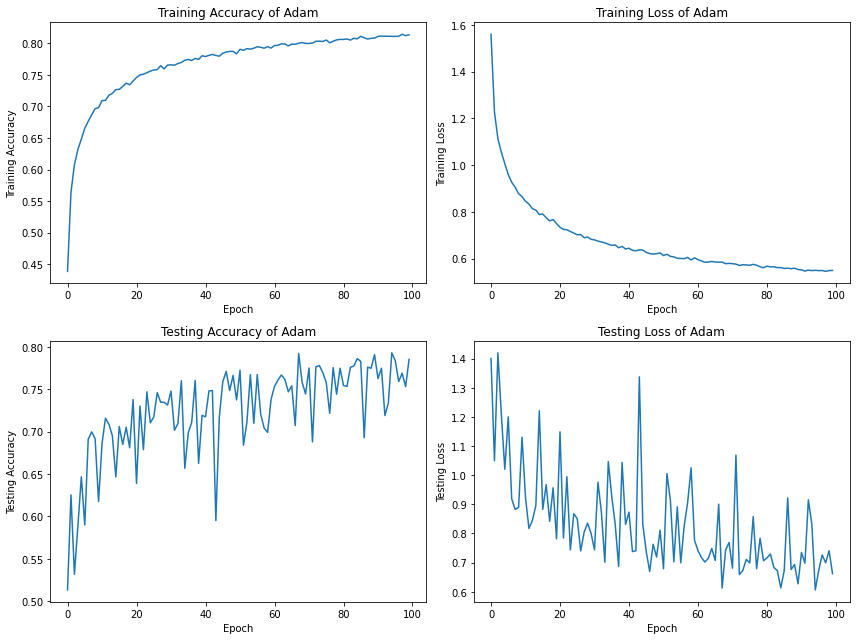

In [9]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(range(num_epoch), accuracy_lst_train)
axs[0, 0].set_title('Training Accuracy of Adam')
axs[0, 0].set(xlabel='Epoch', ylabel='Training Accuracy')

axs[0, 1].plot(range(num_epoch), loss_lst_train)
axs[0, 1].set_title('Training Loss of Adam')
axs[0, 1].set(xlabel='Epoch', ylabel='Training Loss')

axs[1, 0].plot(range(num_epoch), accuracy_lst_val)
axs[1, 0].set_title('Testing Accuracy of Adam')
axs[1, 0].set(xlabel='Epoch', ylabel='Testing Accuracy')

axs[1, 1].plot(range(num_epoch), loss_lst_val)
axs[1, 1].set_title('Testing Loss of Adam')
axs[1, 1].set(xlabel='Epoch', ylabel='Testing Loss')

fig.set_size_inches(12, 9)
fig.tight_layout()